# Pivotal method vs Percentile Method

In this notebook we will explore the difference between the **pivotal** and **percentile** bootstrapping methods. 

tldr -
* The **percentile method** generates a bunch of re-samples and esimates confidence intervals based on the percentile values of those re-samples. 
* The **pivotal method** is similar to percentile but does a correction for the fact that your input sample may not be a good representation of your population. Bootstrapped uses this as the default.

We will show that the pviotal method has generally better power. This does come at a cost - the pivotal method can warp the confidence interval to give non-sencical interval values.

See [Link1](https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf), [Link2](http://www.stat.cmu.edu/~cshalizi/402/lectures/08-bootstrap/lecture-08.pdf) for explanations of both methods.

In [37]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import numpy.random as npr

In [38]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.power as bs_power

### Setup
The bootstrap is based on a sample of your larger population. A sample is only as good as how representitave it is. If you happen to be unlucky in your sample then you are going to make some very bad inferences! 

We pick the exponential distribution because it should differentiate the difference between the two methods somewhat. We will also look at an extreme case.

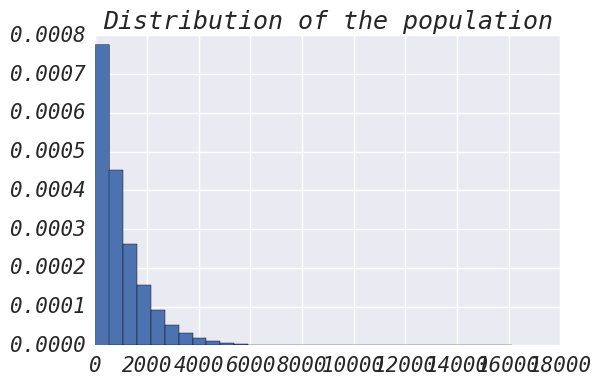

In [39]:
population = np.random.exponential(scale=1000, size=500000)

# Plot the population
count, bins, ignored = plt.hist(population, 30, normed=True)

plt.title('Distribution of the population')
plt.show()

In [40]:
population = pd.Series(population)

In [41]:
# Do a bunch of simpulations and track the percent of the time the error bars overlap the true mean
def bootstrap_vs_pop_mean(population, num_samples, is_pivotal, num_loops=3000):
    population_mean = population.mean()
    pop_results = []

    for _ in range(num_loops):
        samples = population.sample(num_samples)
        result = bs.bootstrap(samples.values, stat_func=bs_stats.mean, is_pivotal=is_pivotal)

        # we want to 0 center this for our power plotting below
        # we want our error bars to overlap zero
        result = result - population_mean

        pop_results.append(result)
    return pop_results

In [42]:
def bounds_squared_distance(results):
    '''The squared distance from zero for both the lower and the upper bound
    This is a rough measure of how 'good' the confidence intervals are in terms of near misses vs extreme misses.
    
    It is minimized when (1) the confidence interval is symmetric over zero and (2) when it is narrow.
    '''
    return np.sum([r.upper_bound**2 for r in results]) + np.sum([r.lower_bound**2 for r in results])

def squared_dist_ratio(x, y):
    'Compare bounds_squared_distance for two sets of bootstrap results'
    return bounds_squared_distance(x) / bounds_squared_distance(y)

### Pivotal vs Percentile for very small input sample size - 10 elements

In [43]:
pivotal_tiny_sample_count = bootstrap_vs_pop_mean(population, num_samples=10, is_pivotal=True)
percentile_tiny_sample_count = bootstrap_vs_pop_mean(population, num_samples=10, is_pivotal=False)

In [44]:
squared_dist_ratio(pivotal_tiny_sample_count, percentile_tiny_sample_count)

0.98990672011763114

                      Percent
Insignificant          84.933
Negative               52.533
Negative Significant   13.400
Positive               47.467
Positive Significant    1.667


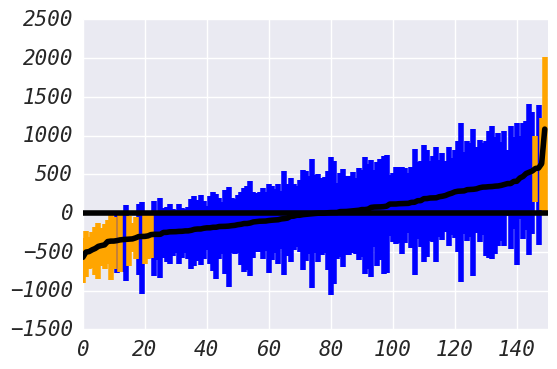

In [45]:
# more insignificant results is better
print(bs_power.power_stats(pivotal_tiny_sample_count))
bs_power.plot_power(pivotal_tiny_sample_count[::20])

                      Percent
Insignificant          84.833
Negative               54.800
Negative Significant   13.100
Positive               45.200
Positive Significant    2.067


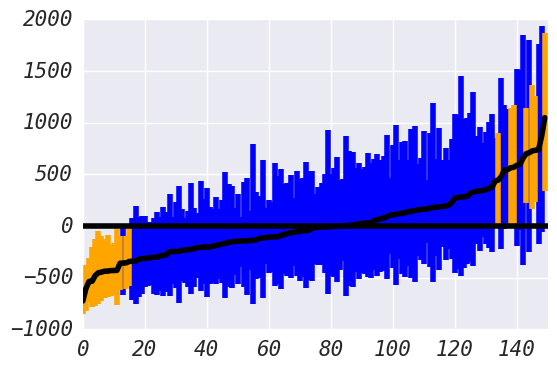

In [46]:
# more insignificant results is better
print(bs_power.power_stats(percentile_tiny_sample_count))
bs_power.plot_power(percentile_tiny_sample_count[::20])

### Pivotal vs Percentile for small input sample size - 100 elements

In [47]:
pivotal_small_sample_count = bootstrap_vs_pop_mean(population, num_samples=100, is_pivotal=True)
percentile_small_sample_count = bootstrap_vs_pop_mean(population, num_samples=100, is_pivotal=False)

In [48]:
squared_dist_ratio(pivotal_small_sample_count, percentile_small_sample_count)

0.98164440864935931

                      Percent
Insignificant          94.067
Negative               50.600
Negative Significant    5.133
Positive               49.400
Positive Significant    0.800


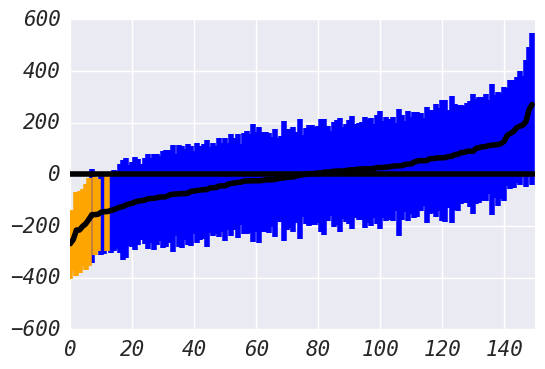

In [49]:
print(bs_power.power_stats(pivotal_small_sample_count))
bs_power.plot_power(pivotal_small_sample_count[::20])

                      Percent
Insignificant          93.033
Negative               51.667
Negative Significant    5.067
Positive               48.333
Positive Significant    1.900


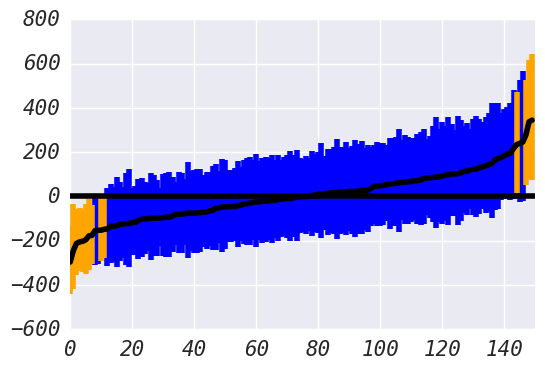

In [50]:
print(bs_power.power_stats(percentile_small_sample_count))
bs_power.plot_power(percentile_small_sample_count[::20])

### Pivotal vs Percentile for medium input sample size - 1000 elements

In [51]:
pivotal_med_sample_count = bootstrap_vs_pop_mean(population, num_samples=1000, is_pivotal=True)
percentile_med_sample_count = bootstrap_vs_pop_mean(population, num_samples=1000, is_pivotal=False)

In [52]:
squared_dist_ratio(pivotal_med_sample_count, percentile_med_sample_count)

1.0030288836327641

                      Percent
Insignificant          95.133
Negative               48.267
Negative Significant    2.933
Positive               51.733
Positive Significant    1.933


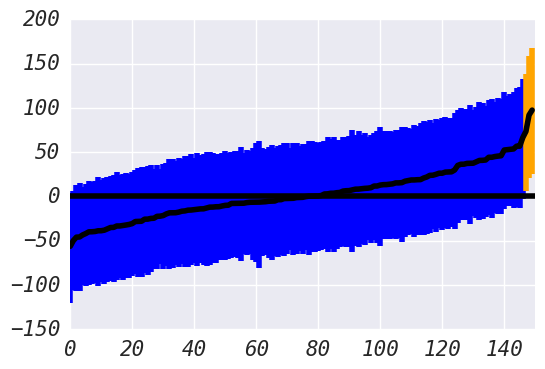

In [53]:
print(bs_power.power_stats(pivotal_med_sample_count))
bs_power.plot_power(pivotal_med_sample_count[::20])

                      Percent
Insignificant          94.900
Negative               51.167
Negative Significant    3.200
Positive               48.833
Positive Significant    1.900


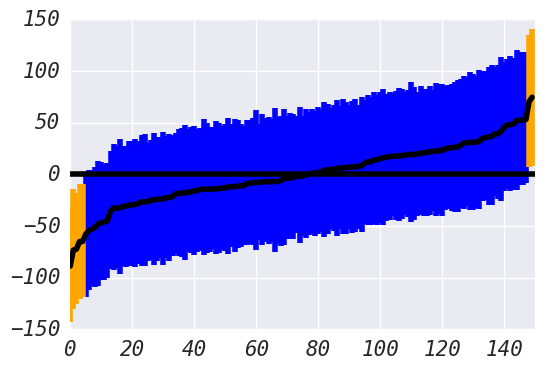

In [54]:
print(bs_power.power_stats(percentile_med_sample_count))
bs_power.plot_power(percentile_med_sample_count[::20])

### Pivotal vs Percentile for somewhat large input sample size - 10k elements

### Bad Populaiton

In [55]:
bad_population = pd.Series([1]*10000 + [100000])

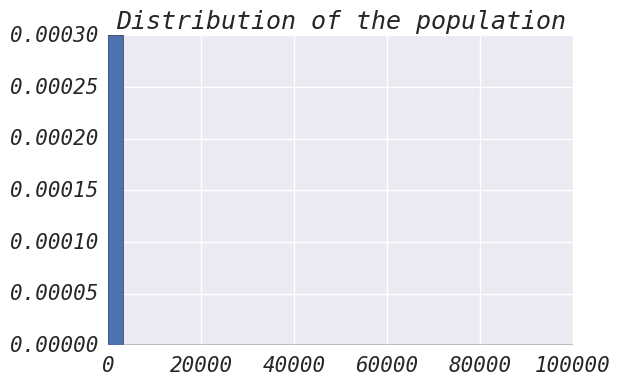

In [56]:
# Plot the population
count, bins, ignored = plt.hist(bad_population, 30, normed=True)

plt.title('Distribution of the population')
plt.show()

In [57]:
samples = bad_population.sample(10000)
print('Mean:\t\t{}'.format(bad_population.mean()))
print('Pivotal CI:\t{}'.format(bs.bootstrap(samples.values, stat_func=bs_stats.mean, is_pivotal=True)))
print('Percentile CI:\t{}'.format(bs.bootstrap(samples.values, stat_func=bs_stats.mean, is_pivotal=False)))

Mean:		10.99890011
Pivotal CI:	10.9999    (-8.9999, 20.9998)
Percentile CI:	10.9999    (1.0, 30.9997)


**Analysis:** The correction from the pivotal method causes a negative lower bound for the estimate in this instance. Generalization: the pivotal correction may not always produce realisitc intervals. In this situation we know that the mean cant be less than one. Still, we have seen from above that the piovtal method seems to be more reliable - this is why it is the default.